In [1]:
# import warnings

# # sklearn warnings
# warnings.filterwarnings("ignore")

In [2]:
from utils import *

2022-12-15 18:06:09.517868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 18:06:09.628881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-15 18:06:09.628895: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-15 18:06:09.644172: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-15 18:06:10.101900: W tensorflow/stream_executor/platform/de

In [3]:
uniqcounts, samplemap, sig, ratio, cov = load_and_preprocess_data()

In [4]:
# some dimensionality reduction (see end of notebook)
(
    embed_cov,
    embed_ratio,
    embed_uniq,
    embed_cov_tsne,
    embed_ratio_tsne,
    embed_uniq_tsne,
    embed_cov_pca,
    embed_ratio_pca,
    embed_uniq_pca,
    embed_ratio_pca,
    embed_uniq_pca,
    embed_sig_pca,
) = get_embeddings(uniqcounts, ratio, cov, sig)

/home/cctrotte/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/cctrotte/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/cctrotte/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/cctrotte/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/cctrotte/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/cctrotte/.local/lib/python3.8/site-packa

In [5]:
# columns suggested by Zsolt for dimensionality reduction
reduced_cols_sig = [
    "A549_hg38_area",
    "SAEC_hg38_area",
    "colon_cluster507_hg38_area",
    "glomerular_placental_clusters833_890_hg38_area",
    "hematopoietic_specific_liquorice_hg38_area",
    "hepatocyte_all_hg38_area",
    "mammary_epithel_cluster2438_hg38_area",
    "prostate_cluster2483_hg38_area",
    "A549_hg38_depth",
    "SAEC_hg38_depth",
    "colon_cluster507_hg38_depth",
    "hematopoietic_specific_liquorice_hg38_depth",
    "hepatocyte_all_hg38_depth",
    "prostate_cluster2483_hg38_depth",
]

## Overall info

The "pipeline" basically does everything. You can directly use either of uniqcounts, samplemap, sig, ratio, cov as features (or some custom combination as long as it has the same format, ie sample name as index, different features as columns).
It tunes a logistic regression with L1 penalty. The penalty is the "C" parameter. As it is implemented, C is actually inversely proportionnal to the penalty. Higher penalty (thus lower C) means less coefficients are selected, reducing overfittng. A feature is dropped if its coefficient is set to 0. 
The pipeline finds optimal parameters using GridSearch with Leave One Out Cross Validation, but you can easily change the CV strategy and the method to select the best model (here model with overall highest precision, recall and f1).

### Experiment 1: 
Train: all baseline and healthy and some selected HN 6 months

Test: the rest


In [6]:
train_samples, test_samples = train_test_custom(
    samplemap,
    train_indices=[
        "HN1-BL",
        "HN2-BL",
        "HN3-BL",
        "HN4-BL",
        "HN5-BL",
        "HN6-BL",
        "HN7-BL",
        "HV1",
        "HV3",
        "HV4",
        "HV5",
        "HV6",
        "HV7",
        "HV8",
        "OMD1-BL",
        "OMD3-BL",
        "OMD4-BL",
        "OMD5-BL",
        "OMD6-BL",
        "OMD7-BL",
        "OMD8-BL",
        "OMD9-BL",
        "PV1",
        "PV3",
        "PV4",
        "PV5",
        "PV6",
        "PV7",
        "PV8",
        "PV9",
        "HN1-d180",
        "HN3-d180",
        "HN4-d180",
        "HN5-d180",
    ],
)

Initially using 960 features
number of splits 34
best parameters {'C': 2}
Number of nonzero coeffs 12
Kept features Int64Index([45, 54, 56, 111, 117, 156, 201, 262, 356, 357, 358, 655], dtype='int64', name='length')
Metrics on train
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        23
           1       0.85      1.00      0.92        11

    accuracy                           0.94        34
   macro avg       0.92      0.96      0.94        34
weighted avg       0.95      0.94      0.94        34

Metrics on test
              precision    recall  f1-score   support

           0       0.77      0.85      0.81        27
           1       0.84      0.75      0.79        28

    accuracy                           0.80        55
   macro avg       0.80      0.80      0.80        55
weighted avg       0.80      0.80      0.80        55



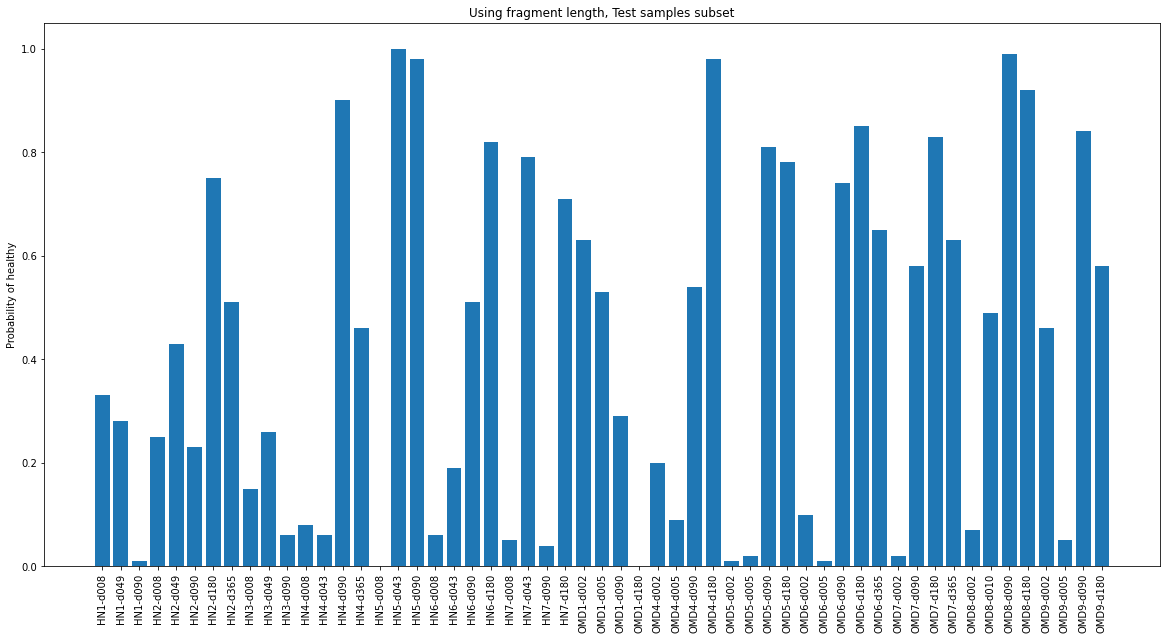

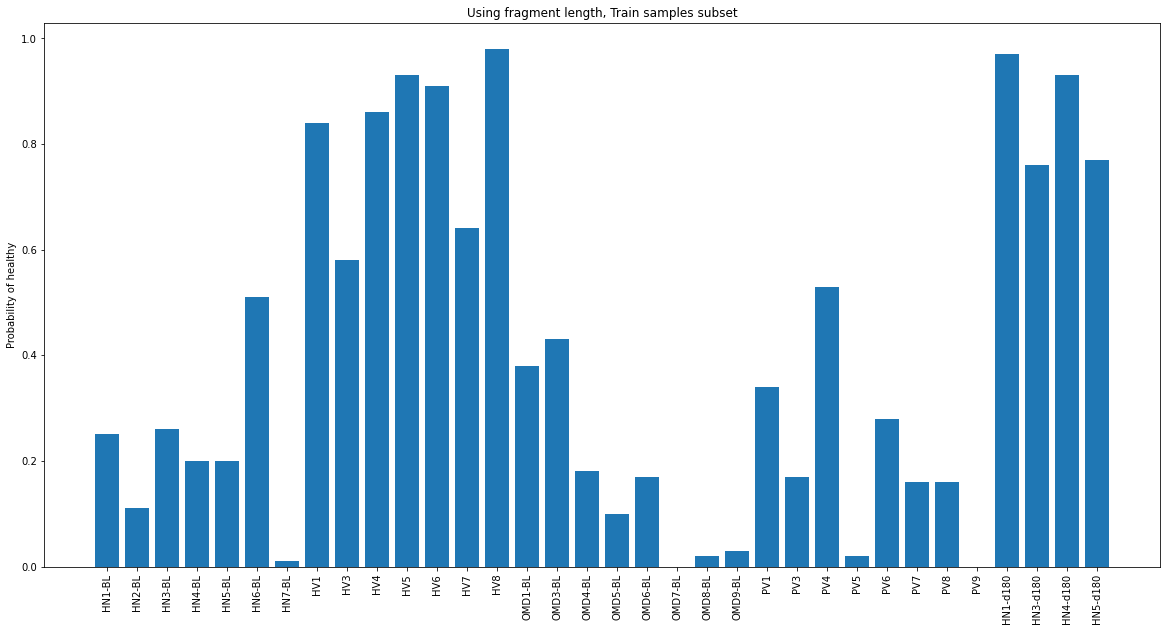

In [7]:
columns_uniqcounts = pipeline(
    uniqcounts, train_samples, test_samples, parameters={"C": [0.1, 1, 2, 5, 10]}
)

### Experiment 2: 
a)
Train : all baselines and healthy except HN

Test : the rest (including all HN samples)

b)
Train : all baselines and healthy

Test : the rest 

Run twice all the cells below, once using train_test with include_hn = True and once with include_hn = False

In [19]:
train_samples, test_samples = train_test(samplemap, include_hn=False)

/home/cctrotte/krauthammer/bioinfo/utils.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_samples["labels"] = [
/home/cctrotte/krauthammer/bioinfo/utils.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_samples["labels"] = [


Using fragment length as features
Initially using 960 features
number of splits 23
best parameters {'C': 5}
Number of nonzero coeffs 18
Kept features Int64Index([ 41,  45,  51,  52,  53,  56, 111, 112, 113, 117, 118, 120, 169,
            199, 200, 201, 351, 989],
           dtype='int64', name='length')
Metrics on train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         7

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23

Metrics on test
              precision    recall  f1-score   support

           0       0.65      0.65      0.65        34
           1       0.62      0.62      0.62        32

    accuracy                           0.64        66
   macro avg       0.64      0.64      0.64        66
weighted avg       0.64      0.64      0.64        66

Using c

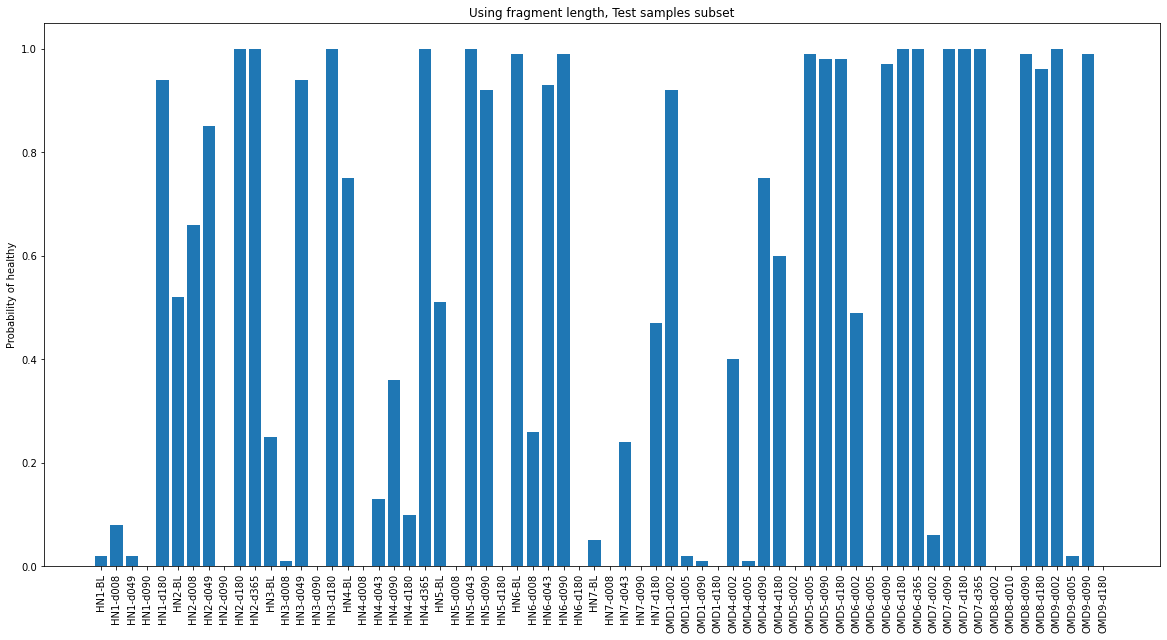

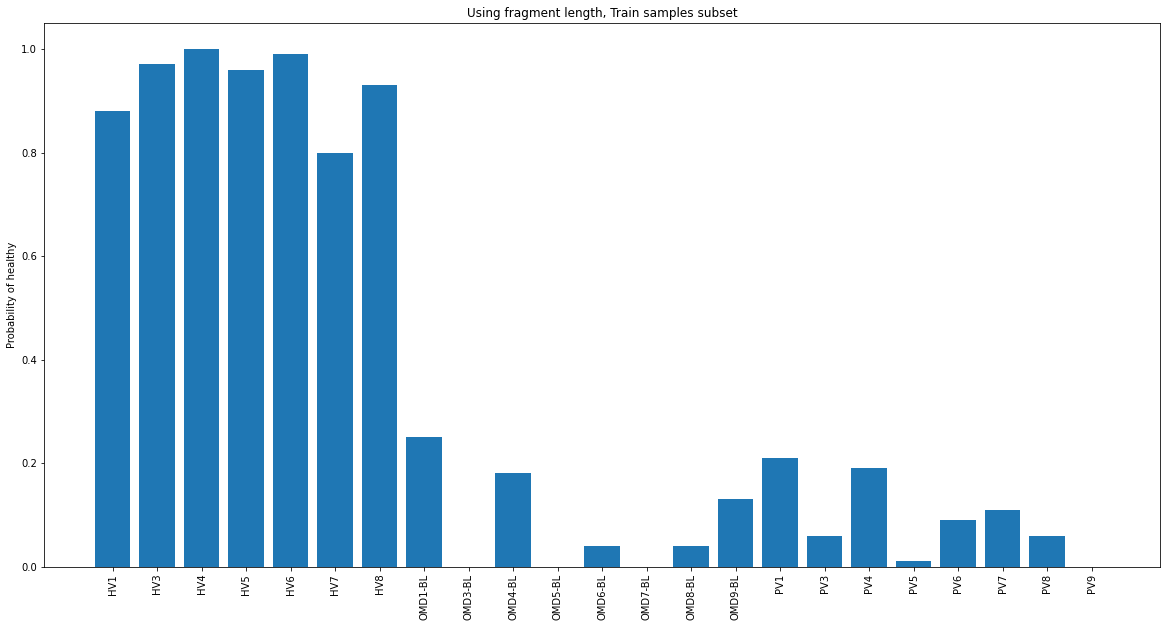

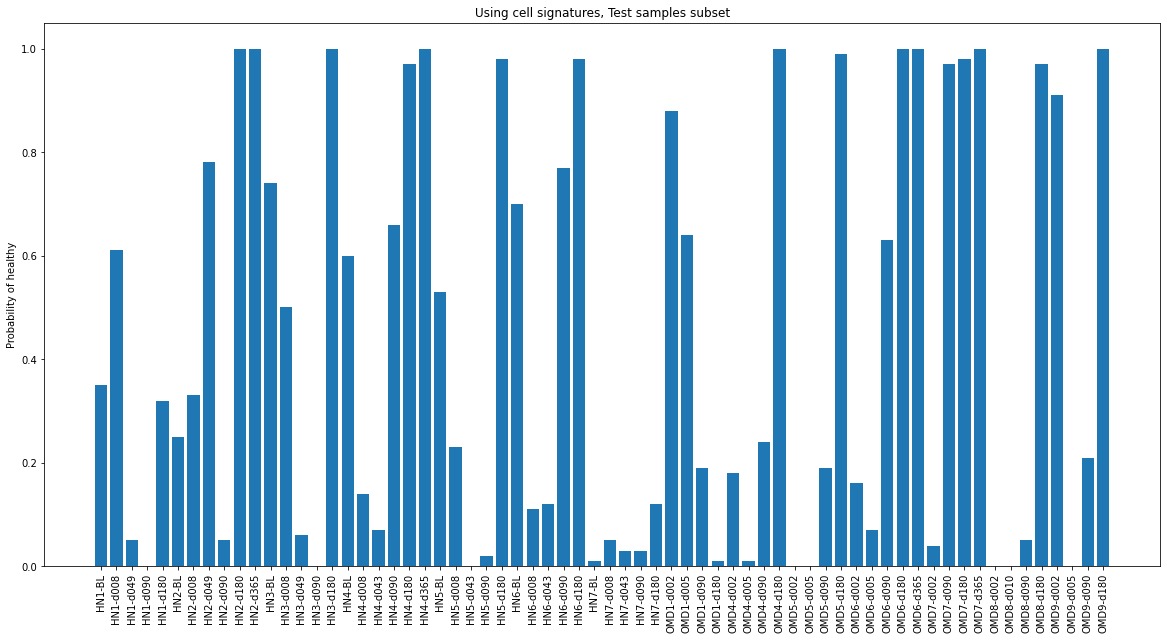

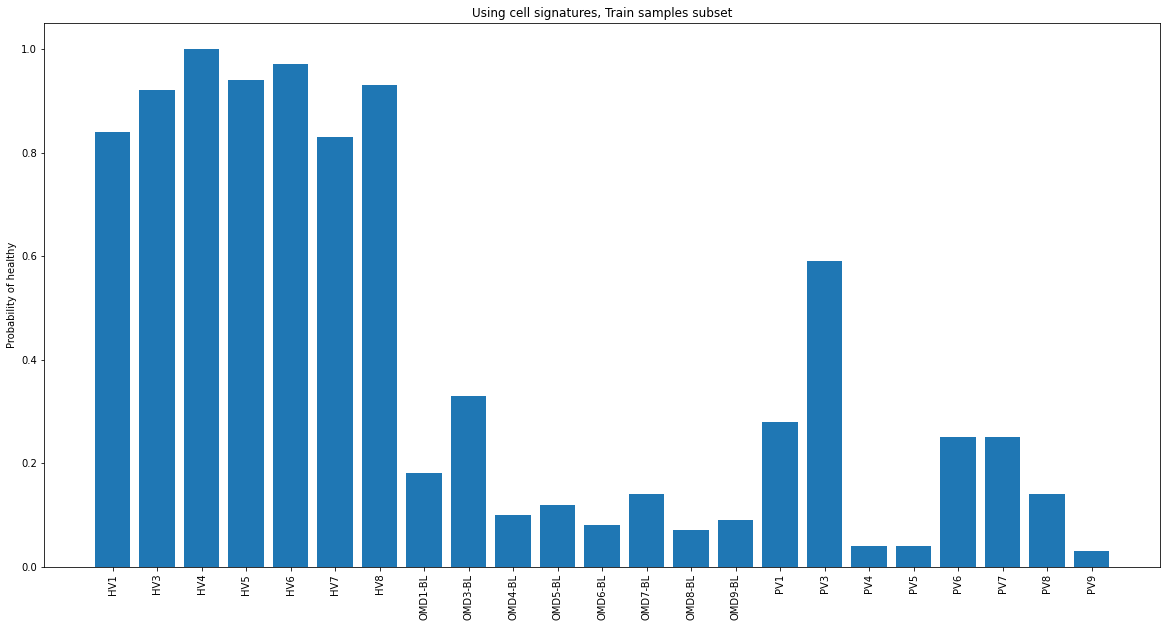

In [32]:
for feature_df in [uniqcounts, sig]:
    print(f"Using {feature_df.name} as features")
    columns_uniqcounts = pipeline(
        feature_df, train_samples, test_samples, parameters={"C": [0.1, 1, 2, 5, 10]}
    )

Initially using 960 features
number of splits 23
best parameters {'C': 2}
Number of nonzero coeffs 15
Kept features Int64Index([41, 42, 45, 51, 52, 111, 112, 113, 118, 120, 169, 200, 201, 662,
            989],
           dtype='int64', name='length')
Metrics on train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         7

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23

Metrics on test
              precision    recall  f1-score   support

           0       0.59      0.56      0.58        34
           1       0.56      0.59      0.58        32

    accuracy                           0.58        66
   macro avg       0.58      0.58      0.58        66
weighted avg       0.58      0.58      0.58        66



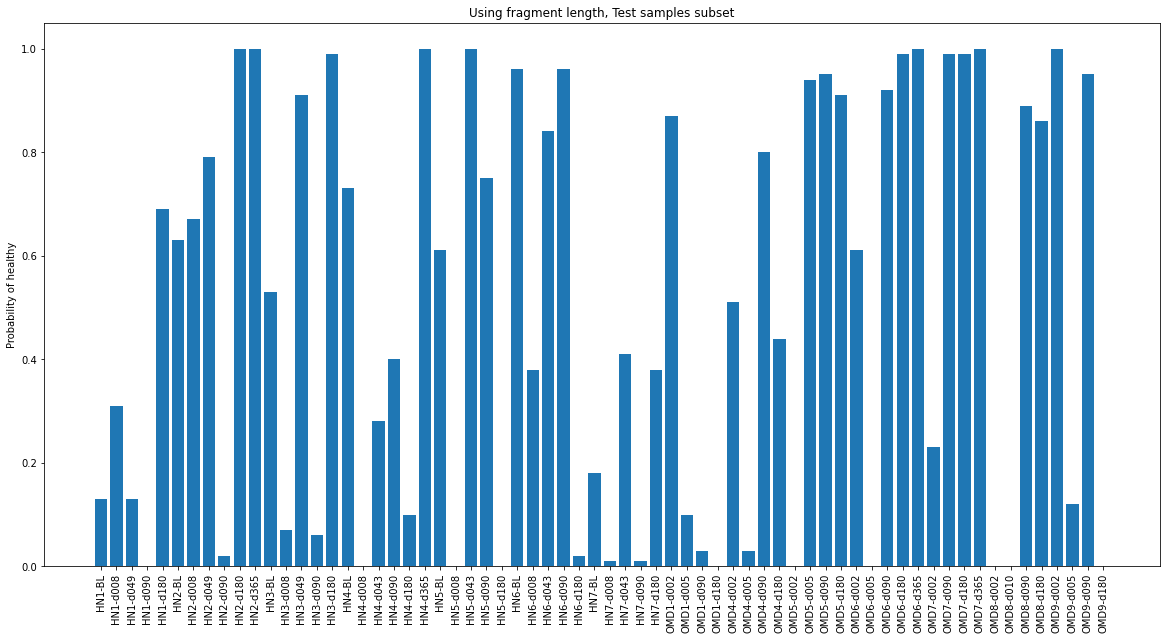

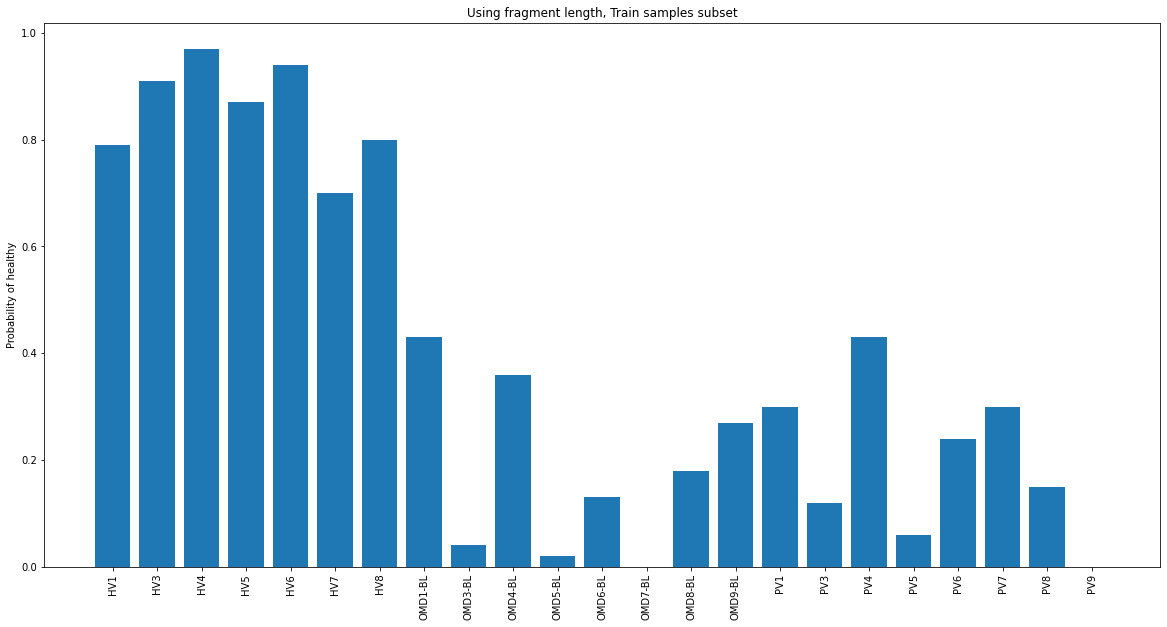

In [34]:
# try to enforce more regularization
columns_uniqcounts = pipeline(
    uniqcounts, train_samples, test_samples, parameters={"C": [1, 2, 3]}
)

Initially using 14 features
number of splits 23
best parameters {'C': 5}
Number of nonzero coeffs 8
Kept features Index(['A549_hg38_area', 'colon_cluster507_hg38_area',
       'glomerular_placental_clusters833_890_hg38_area',
       'mammary_epithel_cluster2438_hg38_area', 'A549_hg38_depth',
       'hematopoietic_specific_liquorice_hg38_depth',
       'hepatocyte_all_hg38_depth', 'prostate_cluster2483_hg38_depth'],
      dtype='object', name='region-set')
Metrics on train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         7

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23

Metrics on test
              precision    recall  f1-score   support

           0       0.67      0.85      0.75        34
           1       0.78      0.56      0.65        32

    accuracy    

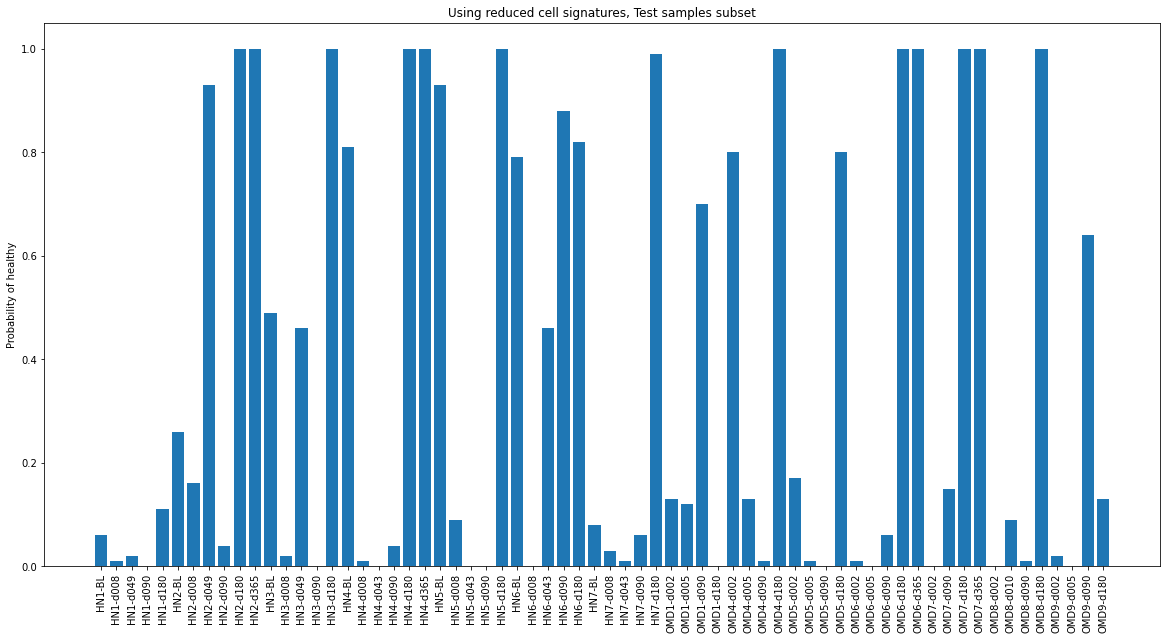

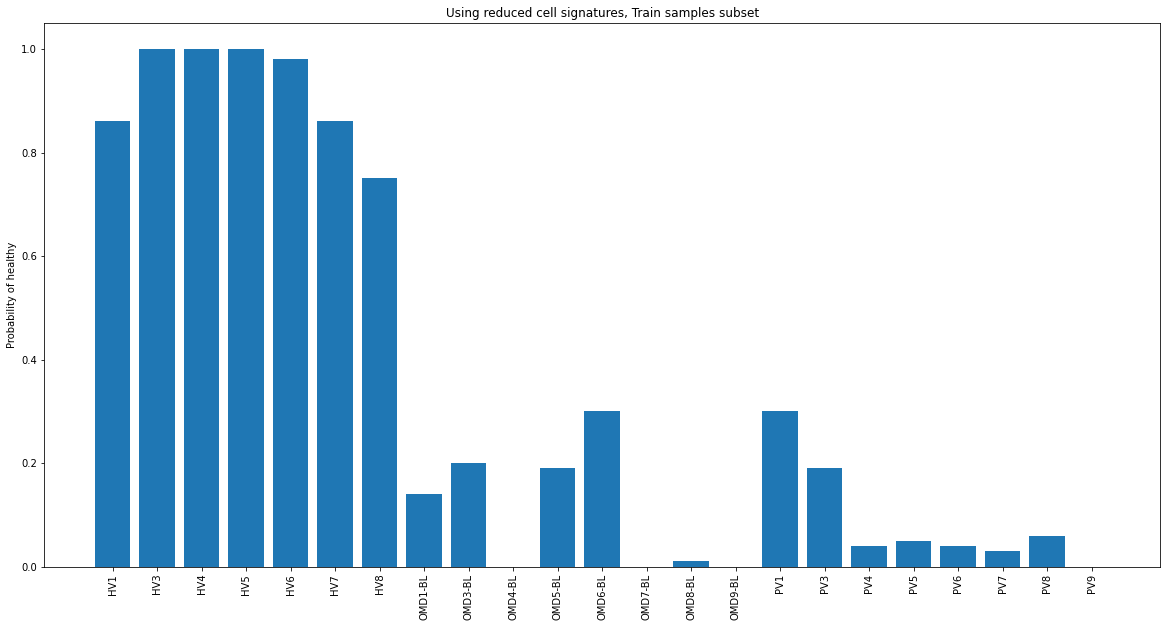

In [22]:
# reduced signatures
features = sig[reduced_cols_sig].copy()
features.name = "reduced cell signatures"
columns_sig_reduced = pipeline(
    features,
    train_samples,
    test_samples,
    parameters={"C": [3, 5, 10]},
)

Initially using 960 features
number of splits 23
best parameters {'C': 0.5}
Number of nonzero coeffs 7
Kept features Int64Index([42, 111, 120, 201, 202, 659, 662], dtype='int64', name='length')
Metrics on train
              precision    recall  f1-score   support

           0       1.00      0.56      0.72        16
           1       0.50      1.00      0.67         7

    accuracy                           0.70        23
   macro avg       0.75      0.78      0.69        23
weighted avg       0.85      0.70      0.70        23

Metrics on test
              precision    recall  f1-score   support

           0       0.48      0.41      0.44        34
           1       0.46      0.53      0.49        32

    accuracy                           0.47        66
   macro avg       0.47      0.47      0.47        66
weighted avg       0.47      0.47      0.47        66

Int64Index([42, 111, 120, 201, 202, 659, 662], dtype='int64', name='length')


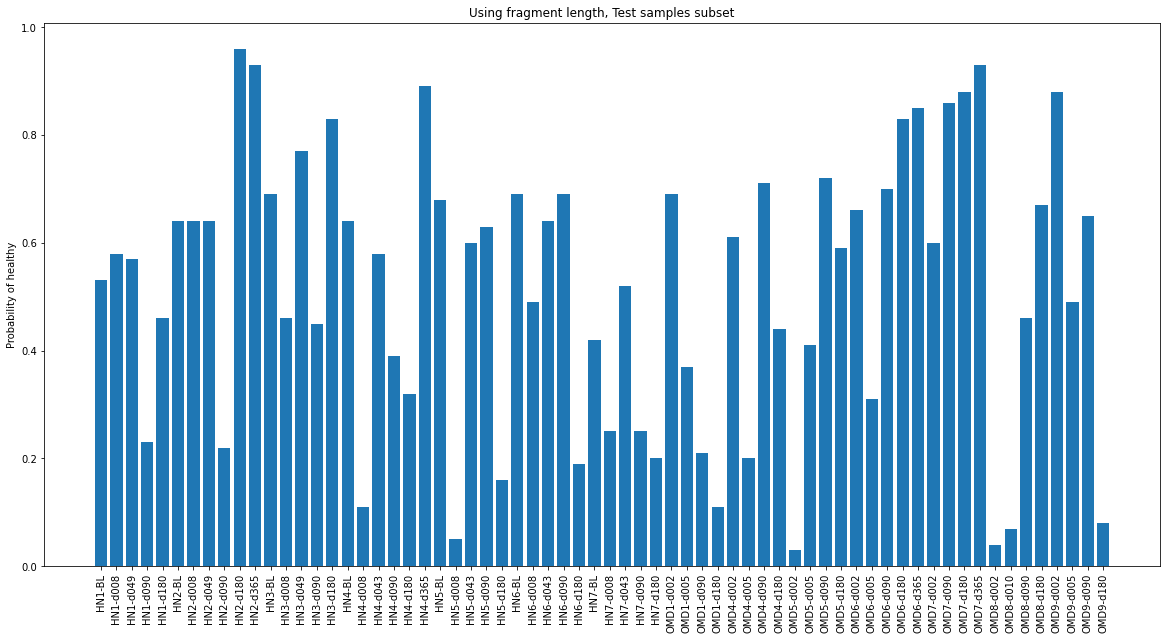

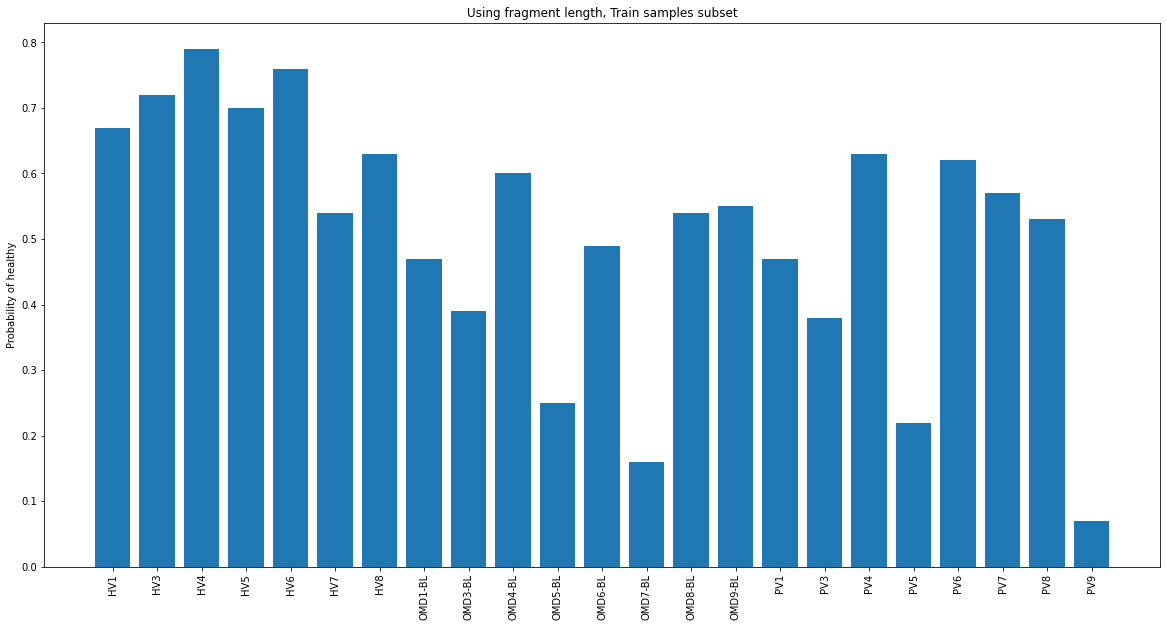

In [23]:
# uniqcounts with more regularization
columns_uniqcounts_reduced = pipeline(
    uniqcounts, train_samples, test_samples, parameters={"C": [0.5]}
)
print(columns_uniqcounts_reduced)

Initially using 25 features
number of splits 23
best parameters {'C': 1}
Number of nonzero coeffs 7
Kept features Index([                                             111,
                                                    201,
                                                    662,
                                       'A549_hg38_area',
                           'colon_cluster507_hg38_area',
       'glomerular_placental_clusters833_890_hg38_area',
                            'hepatocyte_all_hg38_depth'],
      dtype='object')
Metrics on train
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.88      1.00      0.93         7

    accuracy                           0.96        23
   macro avg       0.94      0.97      0.95        23
weighted avg       0.96      0.96      0.96        23

Metrics on test
              precision    recall  f1-score   support

           0       0.59      0.65      0.62      

Index([                                             111,
                                                    201,
                                                    662,
                                       'A549_hg38_area',
                           'colon_cluster507_hg38_area',
       'glomerular_placental_clusters833_890_hg38_area',
                            'hepatocyte_all_hg38_depth'],
      dtype='object')

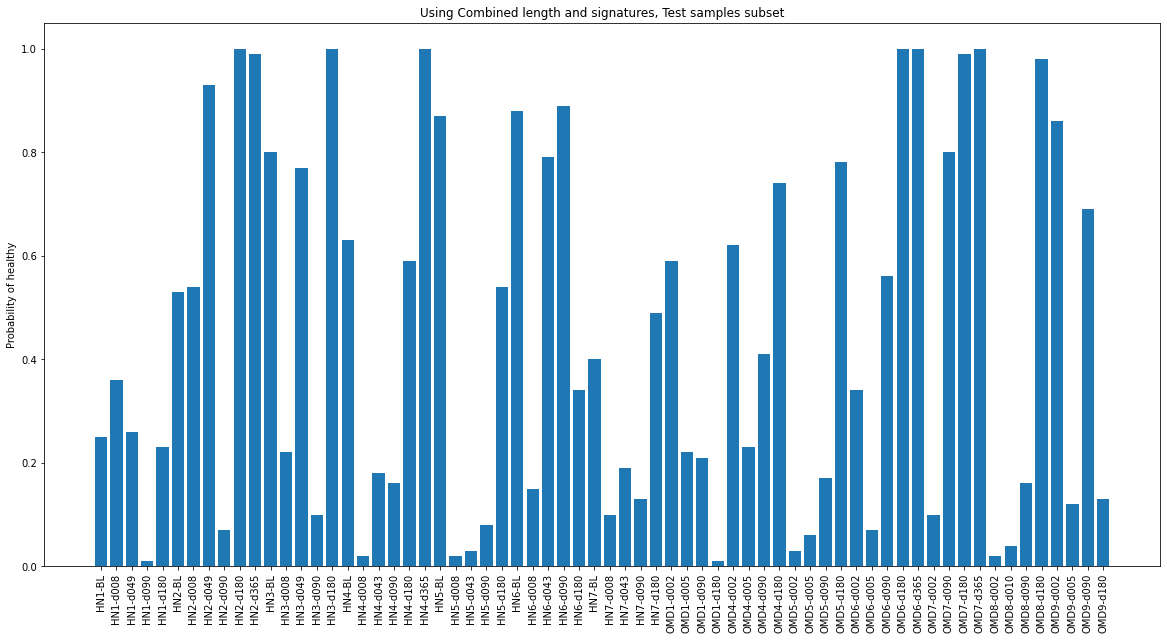

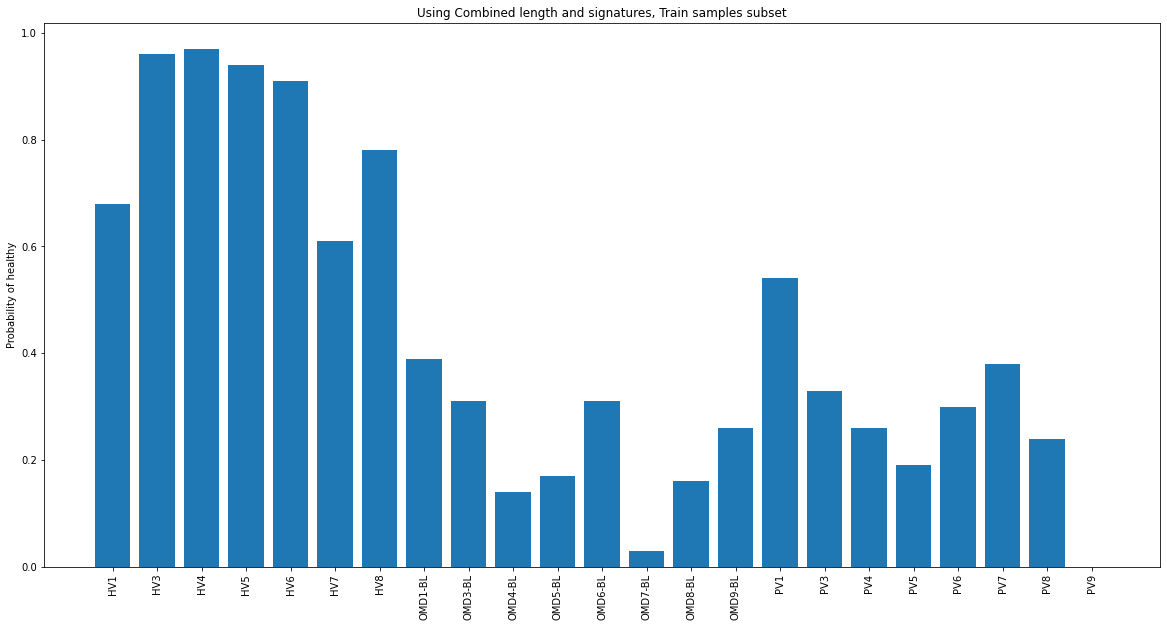

In [24]:
# combining features selected in uniqcounts and sig by the first two models
features = pd.concat((uniqcounts[columns_uniqcounts], sig[columns_sig_reduced]), axis=1)
features.name = "Combined length and signatures"
pipeline(features, train_samples, test_samples)

Initially using 988 features
number of splits 23
best parameters {'C': 1}
Number of nonzero coeffs 10
Kept features Index([      'HPF_lung_fibroblast_cluster1737_hg38_area',
       'glomerular_placental_clusters833_890_hg38_depth',
               'melano_SOX_clusters1863_2205_hg38_depth',
                   'panc_epithel_cluster1974_hg38_depth',
                'skeletal_muscle_cluster1518_hg38_depth',
                                                     107,
                                                     108,
                                                     109,
                                                     110,
                                                     117],
      dtype='object')
Metrics on train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         7

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00   

Index([      'HPF_lung_fibroblast_cluster1737_hg38_area',
       'glomerular_placental_clusters833_890_hg38_depth',
               'melano_SOX_clusters1863_2205_hg38_depth',
                   'panc_epithel_cluster1974_hg38_depth',
                'skeletal_muscle_cluster1518_hg38_depth',
                                                     107,
                                                     108,
                                                     109,
                                                     110,
                                                     117],
      dtype='object')

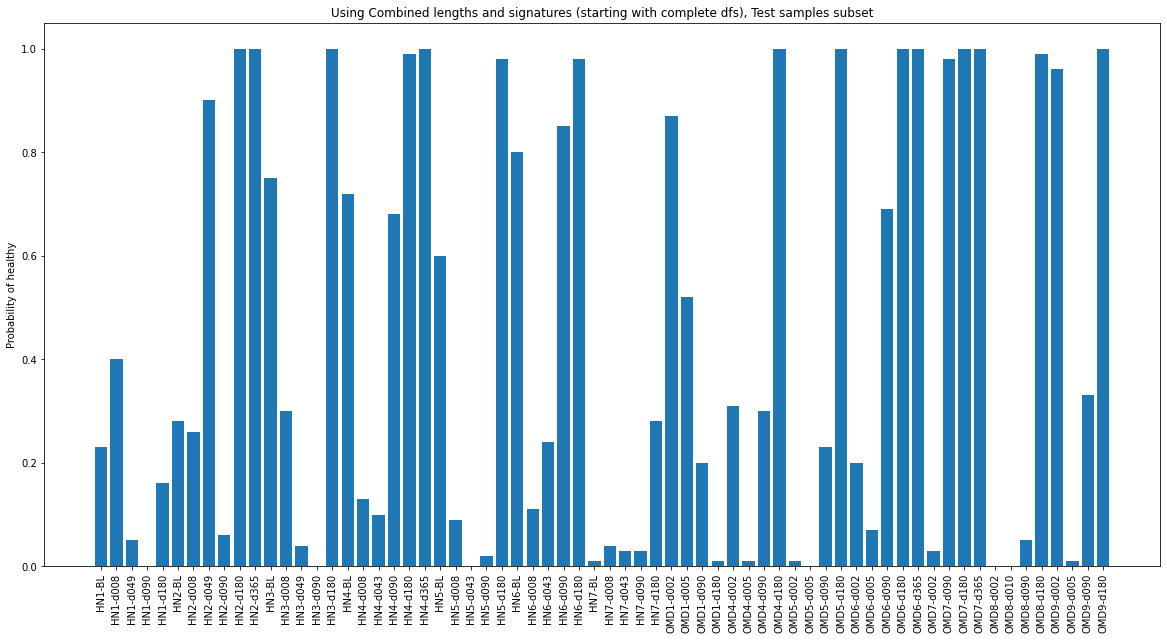

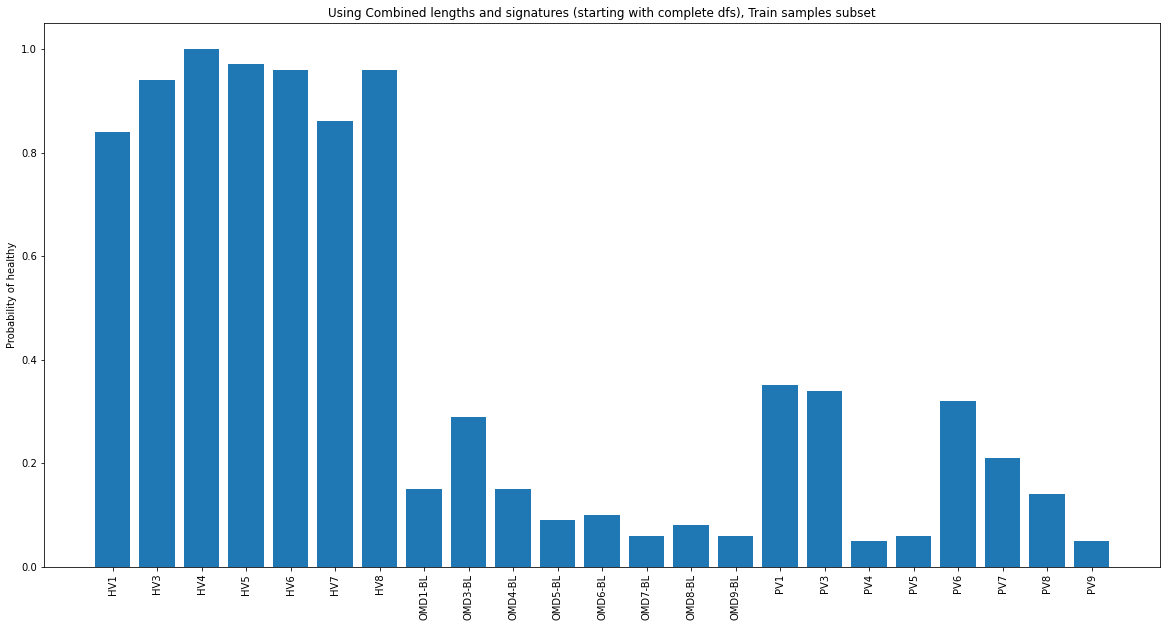

In [25]:
# signatures and uniqcounts (whole dataframes)
features = pd.concat([sig, uniqcounts], axis=1)
features.name = "Combined lengths and signatures (starting with complete dfs)"
pipeline(features, train_samples, test_samples)

Initially using 6 features
number of splits 23
best parameters {'C': 7}
Number of nonzero coeffs 5
Kept features Int64Index([70, 110, 250, 280, 0], dtype='int64')
Metrics on train
              precision    recall  f1-score   support

           0       0.92      0.75      0.83        16
           1       0.60      0.86      0.71         7

    accuracy                           0.78        23
   macro avg       0.76      0.80      0.77        23
weighted avg       0.82      0.78      0.79        23

Metrics on test
              precision    recall  f1-score   support

           0       0.64      0.53      0.58        34
           1       0.58      0.69      0.63        32

    accuracy                           0.61        66
   macro avg       0.61      0.61      0.60        66
weighted avg       0.61      0.61      0.60        66



Int64Index([70, 110, 250, 280, 0], dtype='int64')

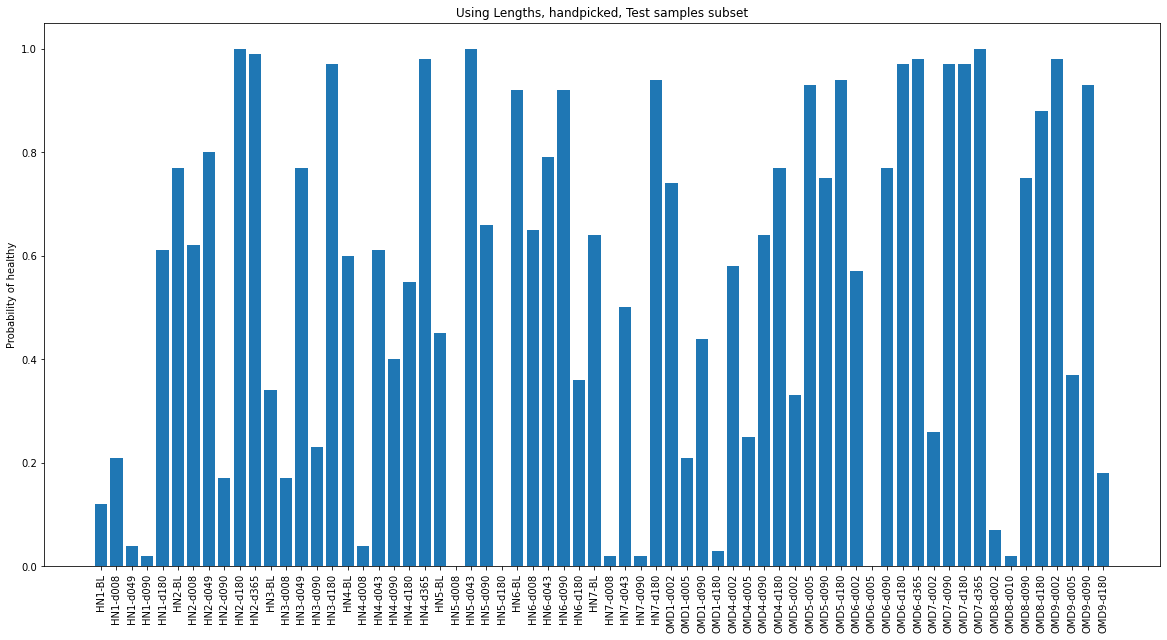

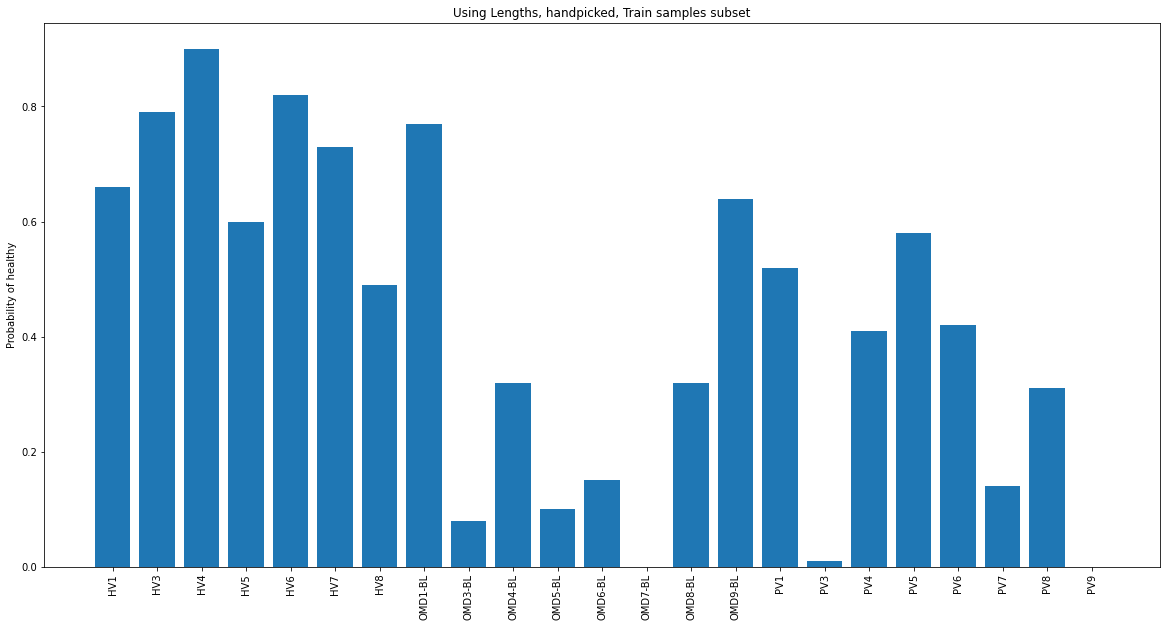

In [26]:
# handpicking some features
features = pd.concat(
    (uniqcounts[[70, 110, 118, 250, 280]], uniqcounts.mean(axis=1)), axis=1
)
features.name = "Lengths, handpicked"
pipeline(
    features, train_samples, test_samples, parameters={"C": [5, 6, 7, 8, 9, 10000]}
)

### Below, some experiments with ratio and coverage, not very convincing

Initially using 28738 features
number of splits 23
best parameters {'C': 10}
Number of nonzero coeffs 68
Kept features Index(['chr1_500001_600000', 'chr1_121900001_122000000',
       'chr1_122000001_122100000', 'chr1_122200001_122300000',
       'chr1_122800001_122900000', 'chr1_124700001_124800000',
       'chr2_87100001_87200000', 'chr2_92000001_92100000',
       'chr2_210600001_210700000', 'chr2_213300001_213400000',
       'chr3_197300001_197400000', 'chr5_46700001_46800000',
       'chr5_49900001_50000000', 'chr5_71000001_71100000',
       'chr6_29800001_29900000', 'chr6_58400001_58500000',
       'chr6_58800001_58900000', 'chr6_59500001_59600000',
       'chr6_59600001_59700000', 'chr6_59700001_59800000',
       'chr7_61100001_61200000', 'chr7_62400001_62500000',
       'chr7_157600001_157700000', 'chr8_35600001_35700000',
       'chr8_39000001_39100000', 'chr8_41500001_41600000',
       'chr8_44200001_44300000', 'chr8_44400001_44500000',
       'chr8_44700001_44800000', 'chr8_44

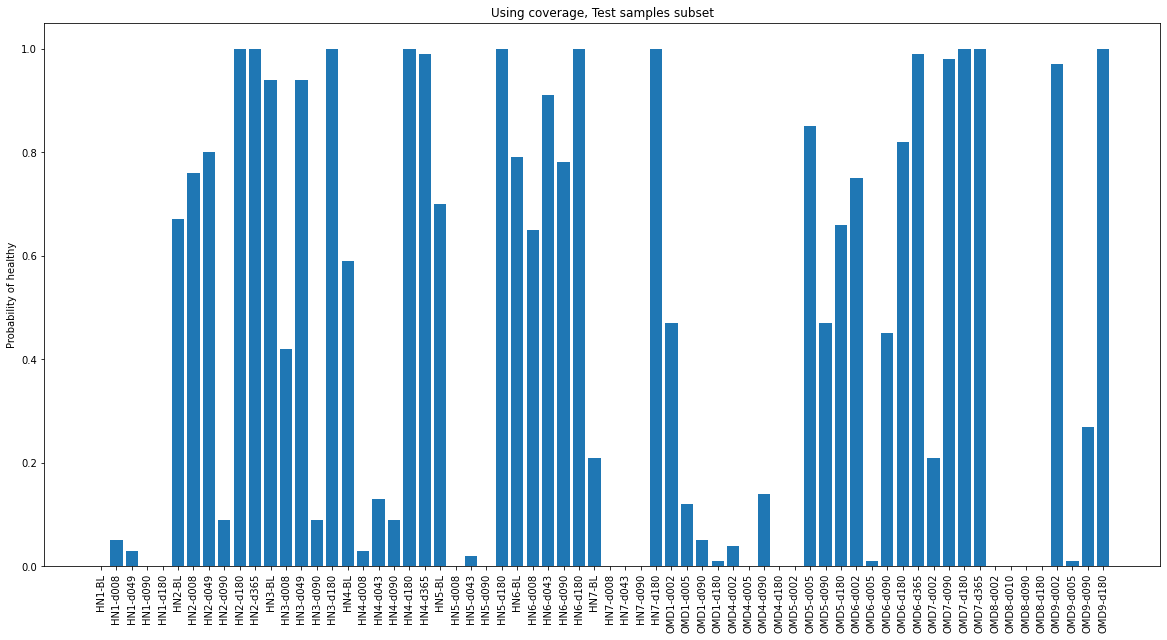

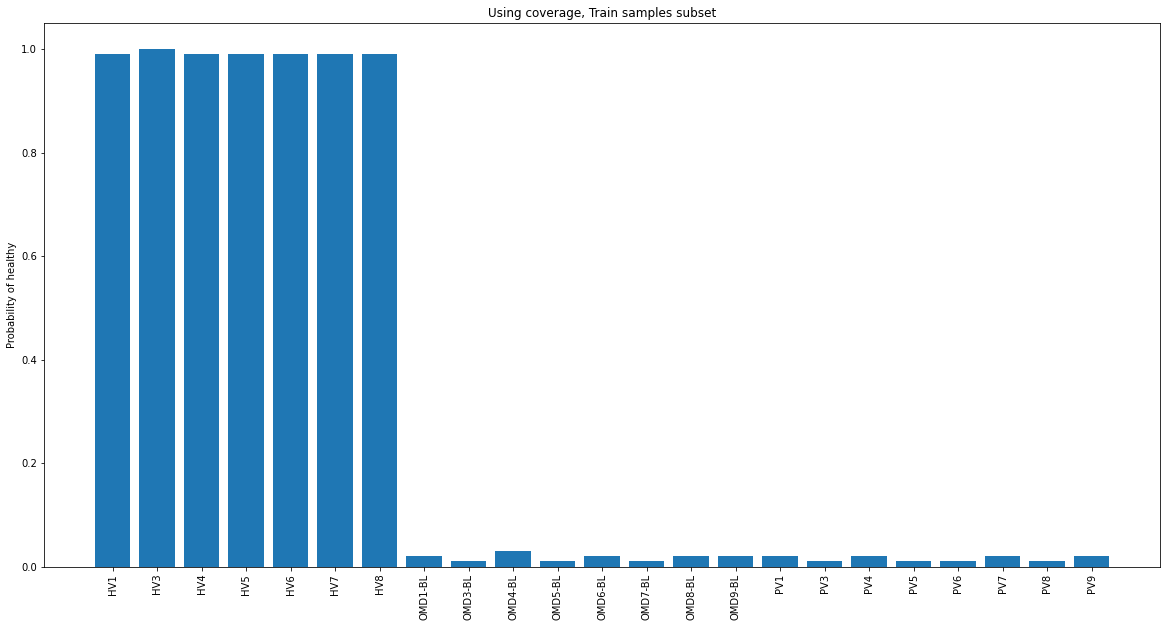

In [27]:
# coverage
columns_cov = pipeline(
    cov, train_samples, test_samples, parameters={"C": [0.5, 1, 2, 10, 100]}
)

Initially using 28738 features
number of splits 23
best parameters {'C': 5}
Number of nonzero coeffs 43
Kept features Index(['chr1_121800001_121900000', 'chr1_123400001_123500000',
       'chr2_92100001_92200000', 'chr3_91700001_91800000',
       'chr3_92500001_92600000', 'chr3_92600001_92700000',
       'chr3_92800001_92900000', 'chr4_50900001_51000000',
       'chr4_68400001_68500000', 'chr5_48500001_48600000',
       'chr6_29200001_29300000', 'chr6_29600001_29700000',
       'chr6_31400001_31500000', 'chr6_58500001_58600000',
       'chr6_65700001_65800000', 'chr6_127800001_127900000',
       'chr7_60600001_60700000', 'chr7_142900001_143000000',
       'chr7_148200001_148300000', 'chr8_700001_800000',
       'chr9_40100001_40200000', 'chr9_43800001_43900000',
       'chr9_62100001_62200000', 'chr9_65100001_65200000',
       'chr10_39600001_39700000', 'chr10_41300001_41400000',
       'chr10_46300001_46400000', 'chr10_133600001_133700000',
       'chr11_7700001_7800000', 'chr12_35500

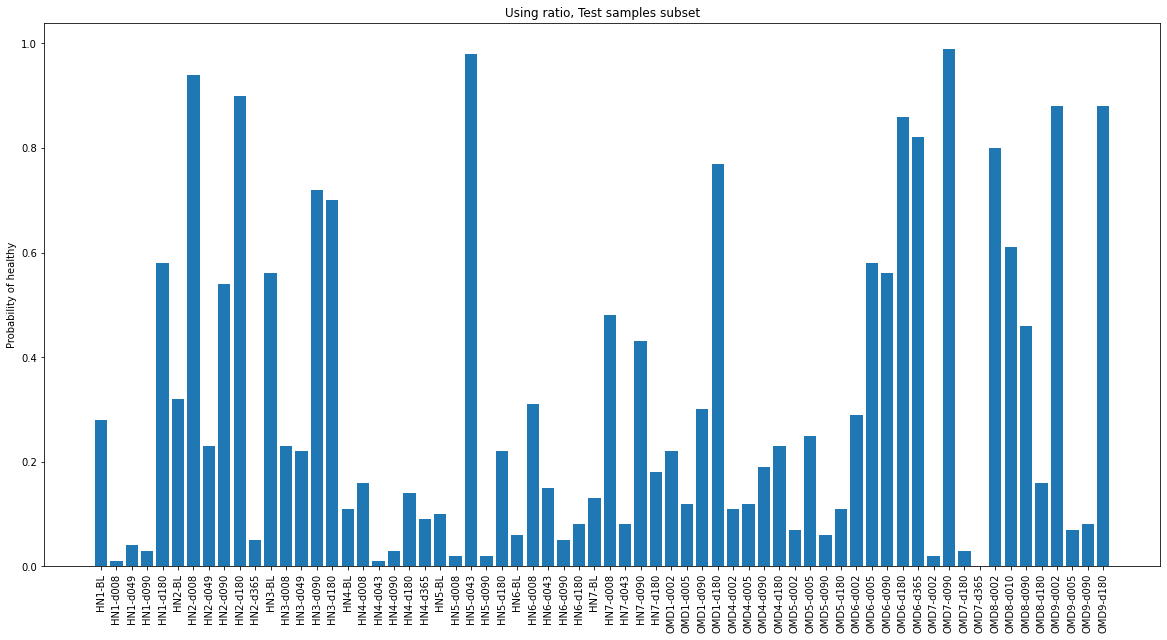

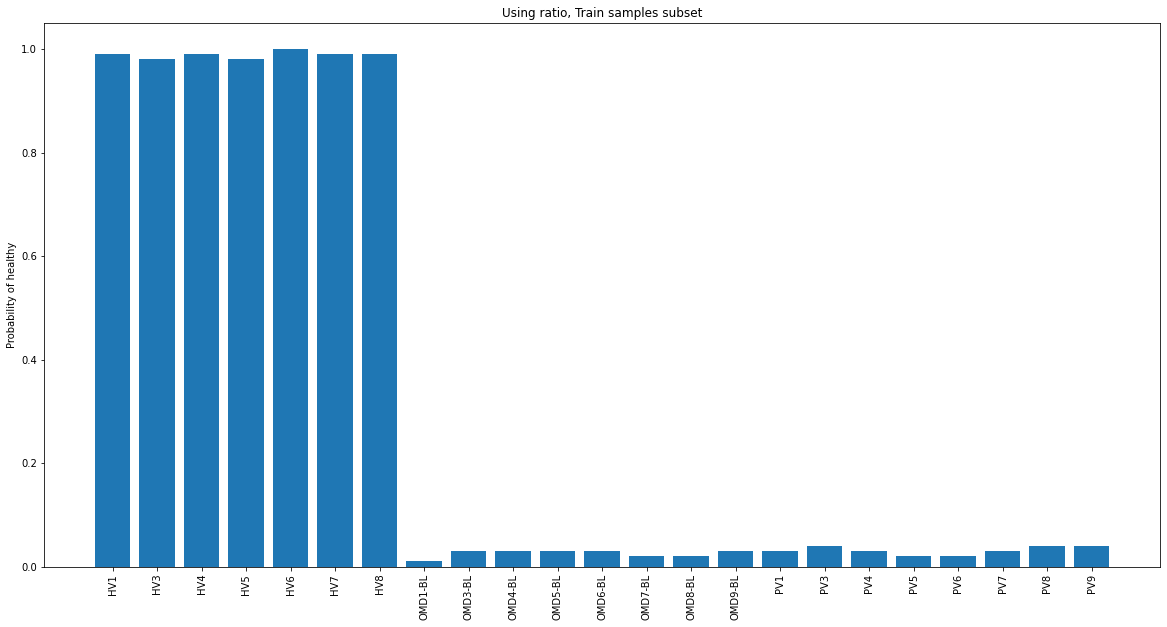

In [28]:
# ratio
columns_ratio = pipeline(
    ratio, train_samples, test_samples, parameters={"C": [0.5, 1, 2, 5]}
)

Initially using 13 features
number of splits 23
best parameters {'C': 10}
Number of nonzero coeffs 7
Kept features Int64Index([111, 120, 201, 662, 0, 0, 0], dtype='int64')
Metrics on train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         7

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23

Metrics on test
              precision    recall  f1-score   support

           0       0.54      0.59      0.56        34
           1       0.52      0.47      0.49        32

    accuracy                           0.53        66
   macro avg       0.53      0.53      0.53        66
weighted avg       0.53      0.53      0.53        66



Int64Index([111, 120, 201, 662, 0, 0, 0], dtype='int64')

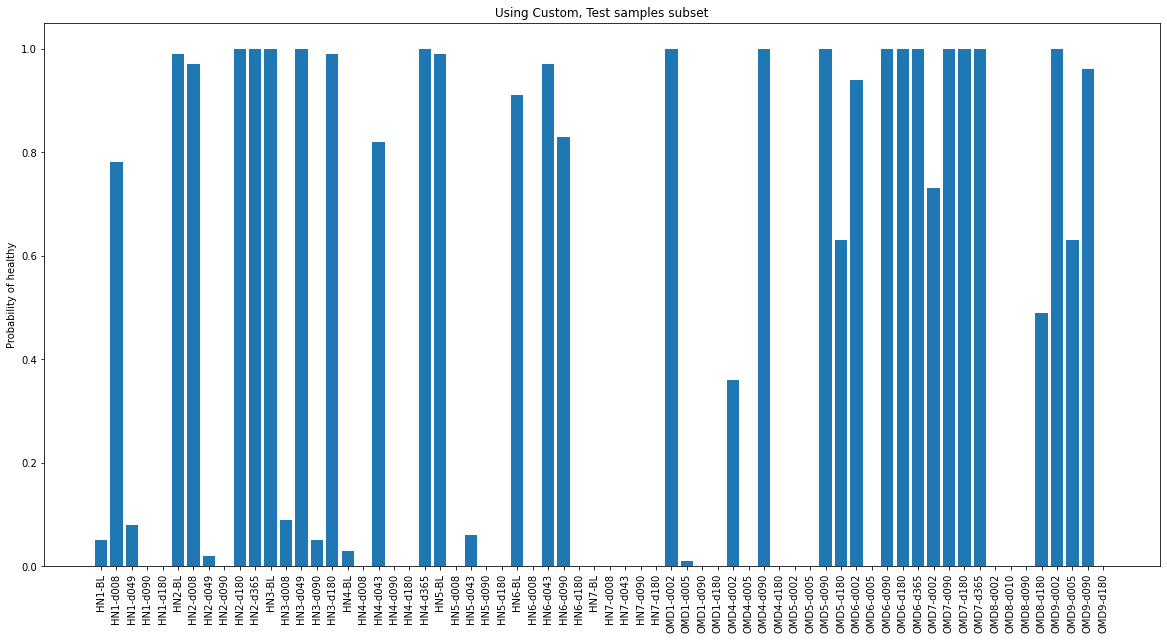

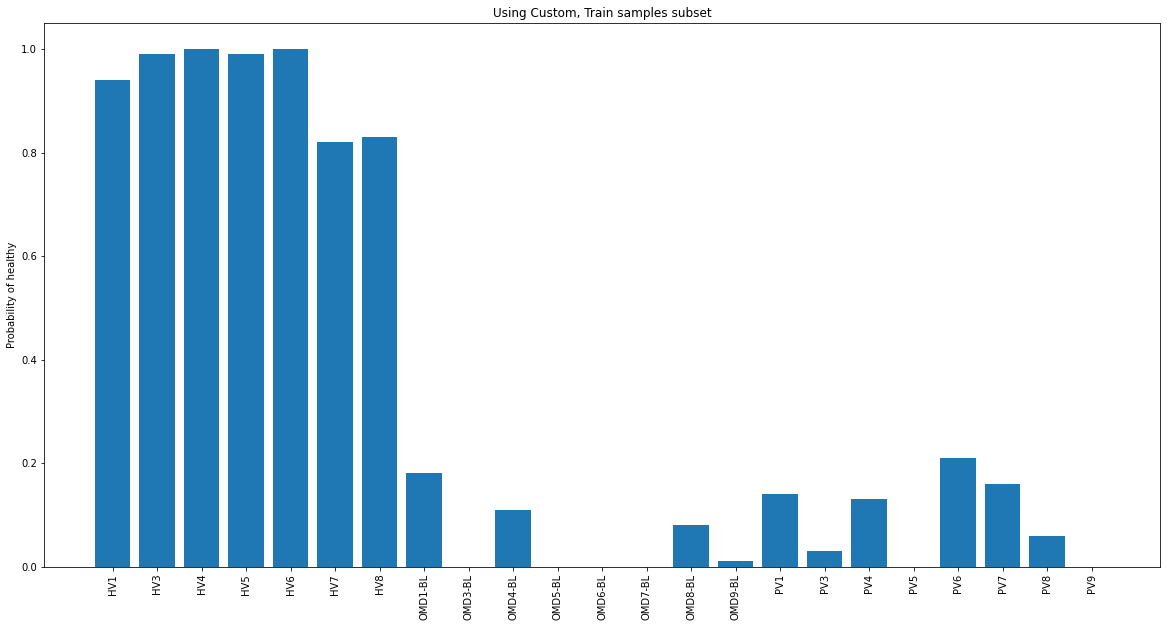

In [29]:
features = pd.concat(
    (
        uniqcounts[columns_uniqcounts_reduced],
        embed_uniq_pca,
        embed_uniq,
        embed_uniq_tsne,
    ),
    axis=1,
)
features.name = "Custom"
pipeline(features, train_samples, test_samples, parameters={"C": [10]})